## Importing Libraries

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import models
import pickle

### If a GPU is configured it should be showed below

In [5]:
print("Gpu",tf.test.gpu_device_name())

Gpu 


## Directories

In [6]:
#path="C:\\Users\\chris\\Documents\\Assignment5\\img-classs"
path="C:\\tareas\\2023\\sistemas inteligentes\\tarea 5\\scenarioDetection\\img-classs"

In [7]:
pathToImagesTrain=path+"\\seg_train\\seg_train"
pathToImagesTest=path+"\\seg_test\\seg_test"
pathToImagesPred=path+"\\seg_pred\\seg_pred"
classes=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Functions

### Process Images

In [8]:
def resizeImages(imagesArray,dim=128):
    newArray=[]
    for image in imagesArray:
        newArray.append(cv2.resize(image, (dim, dim)))
    return newArray

def convertImgsGScale(imagesArray):
    newArray=[]
    for image in imagesArray:
        newArray.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    return newArray

### Get Images From directory Functions

In [9]:
def getImagesFromAFolder(imgDirectory,resize=False,resizeSize=128,gray=False):
    imgArray=[]
    for img in os.listdir(imgDirectory):
        image=cv2.imread(os.path.join(imgDirectory,img))
        imgDim = cv2.resize(image, (150, 150))
        imgArray.append(imgDim)

    if (resize): imgArray= resizeImages(imgArray,resizeSize)
    if (gray): imgArray=convertImgsGScale(imgArray)
    print(np.array(imgArray).shape)
    return imgArray

def getFolderNamesFromDirectory(directory):
    folderNames = []
    for name in os.listdir(directory):
        route = os.path.join(directory, name)
        if os.path.isdir(route):
            folderNames.append(name)
    return folderNames
def getImagesSetWithLabels(pathToImages,resize=False,resizeSize=128,gray=False):
    imgClasses = getFolderNamesFromDirectory(pathToImages)
    classId=0
    totalImgs=0
    channels=3
    if (gray):
        channels=1
    X = []
    Y = []
    print(imgClasses)
    for imgClass in imgClasses:
        print(imgClass)
        imgsFromClass=getImagesFromAFolder(pathToImages+"\\"+imgClass,True,resizeSize,False)
        classLabels = np.ones(len(imgsFromClass))
        totalImgs+=len(imgsFromClass)
        classLabels=classLabels*classId
        classId+=1
        X.extend(imgsFromClass)
        Y.extend(classLabels)
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape((totalImgs, resizeSize, resizeSize, channels))
    return (X,Y)

### Saving and Loading Data

In [10]:
def saveDataPickle(name,data):
    with open(name, 'wb') as file:
        pickle.dump(data, file)
        file.close()
def loadDataPickle(name):
    with open(name, 'rb') as file:
        data = pickle.load(file)
    return data

### Plot statistics from model

In [11]:
def printResults(accuracy,val_accuracy,loss,val_loss):
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def loadModelAndPrintData(path):
    newModel = models.load_model(path)
    # Evaluate the model on the test data using `evaluate`
    print(newModel.summary())
    print("Evaluate on test data")
    results = newModel.evaluate(X_Test, Y_Test, batch_size=32)
    print("test loss, test acc:", results)
    return newModel


# Preprocessing images

In [10]:
exampleImg=cv2.imread(pathToImagesTrain+"\\buildings\\0.jpg")

### Image reshaped to 256 pixels

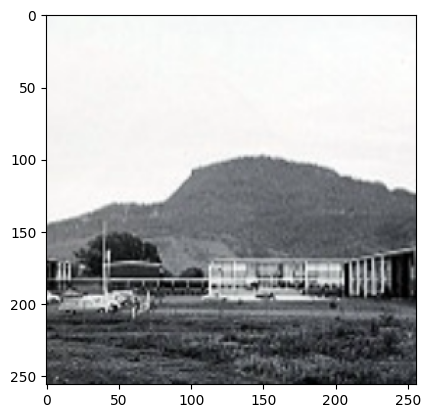

In [11]:
resized256=resizeImages([exampleImg],256)
plt.imshow(resized256[0])
plt.show()

### Image reshaped to 64 pixels

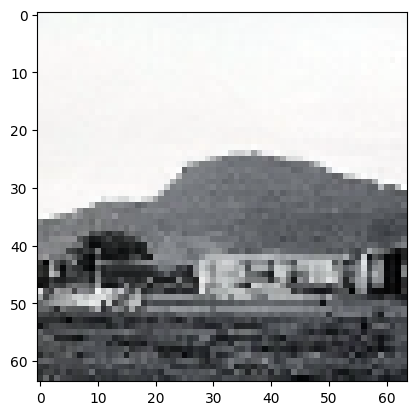

In [12]:
resized64=resizeImages([exampleImg],64)
plt.imshow(resized64[0])
plt.show()

### Image reshaped to 128 pixels

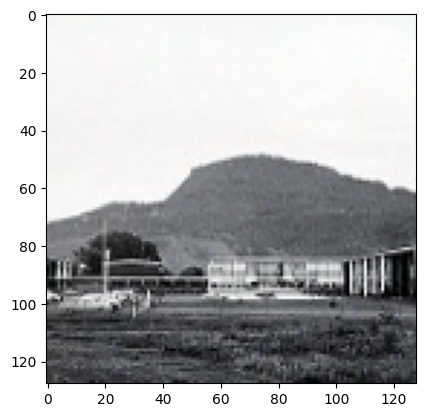

In [13]:
resized128=resizeImages([exampleImg],128)
plt.imshow(resized128[0])
plt.show()

Comparing the images above we decided that it's better to use the one with 128 pixels, because it's not creating fake pixels as the one with 256, on the other hand, the one with 64 pixels is reducing considerably the quality of the image, so in our opinion, its appropriate to use 128 pixels

Regarding the color of the images, it's appropriate to work using RGB because a glacier, a mountain or a forest could be classified easily by taking into account the color

## Generating training and test sets

In [19]:
X_Train,Y_Train=getImagesSetWithLabels(pathToImages=pathToImagesTrain,resize=True,resizeSize=128,gray=False)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
buildings
(2191, 128, 128, 3)
forest


KeyboardInterrupt: 

In [20]:
X_Test,Y_Test=getImagesSetWithLabels(pathToImages=pathToImagesTest,resize=True,resizeSize=128,gray=False)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
buildings


KeyboardInterrupt: 

The first time you run this jupyter you ought to uncomment the next lines of code

In [18]:
#saveDataPickle('imagesProcessedPickles/xTrain2.Pickle',X_Train)
#saveDataPickle('imagesProcessedPickles/yTrain2.Pickle',Y_Train)
#saveDataPickle('imagesProcessedPickles/xTest2.Pickle',X_Test)
#saveDataPickle('imagesProcessedPickles/yTest2.Pickle',Y_Test)

## Training the model

First we load the data we generated before

In [20]:
X_Train=loadDataPickle('imagesProcessedPickles/xTrain2.pickle')
Y_Train=loadDataPickle('imagesProcessedPickles/yTrain2.pickle')
X_Test=loadDataPickle('imagesProcessedPickles/xTest2.pickle')
Y_Test=loadDataPickle('imagesProcessedPickles/yTest2.pickle')

The training set shape is 14034 and the test set shape is 3000

In [12]:
print(X_Train.shape)

(14034, 128, 128, 3)


In [21]:
print(X_Test.shape)

(3000, 128, 128, 3)


We've made several experiments with the network architecture, the most relevant results are shown below

### Second model

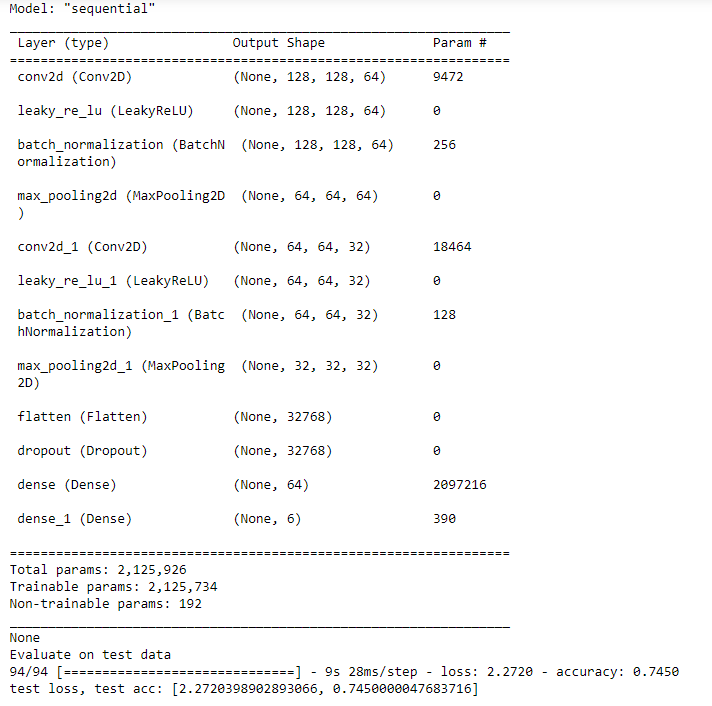



The second model we tried was built using two convolutional layers, each one including the pooling layer and also leaky rely and batch normalization for the peaks we are gonna show below, then we have a dense layer with 64 nodes

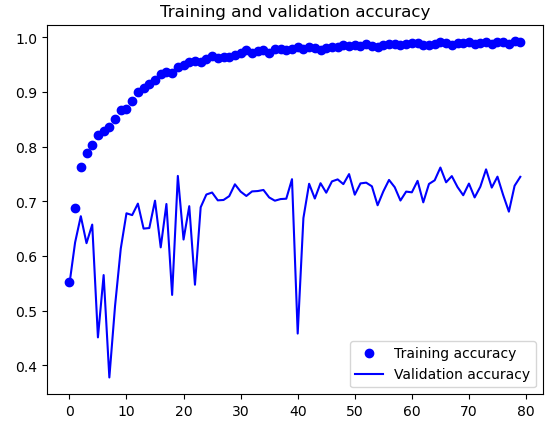


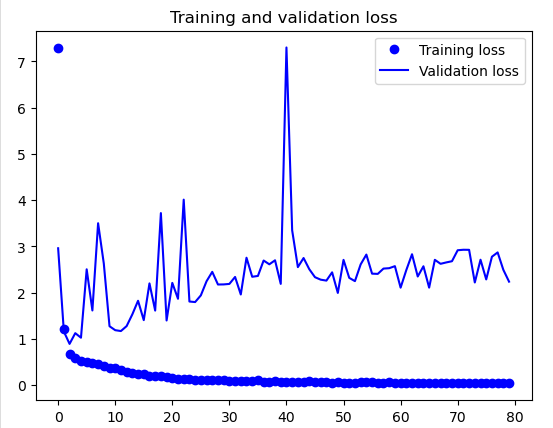

In the results, we can see that the model was overfitting because on average the validation loss was getting higher, even though we had a dropout layer with 0.15 as a parameter,but at the end the model reached almost a 75% of accuracy

### Third model

For the third model we increased the dropout parameter to 0.3 and added one more convolutional layer

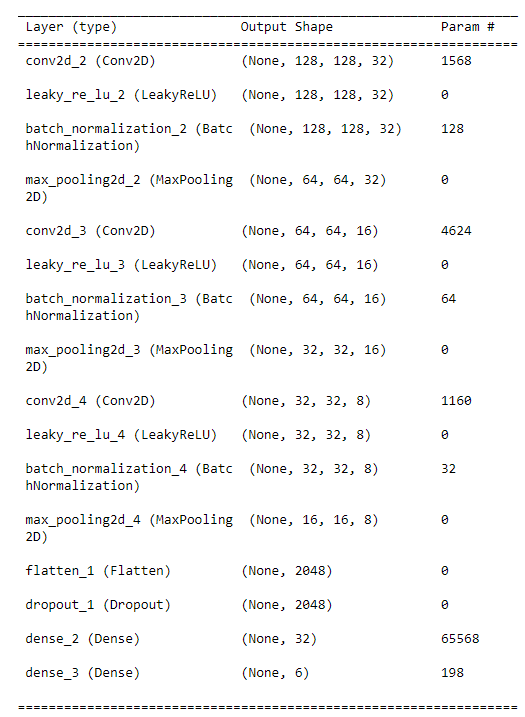

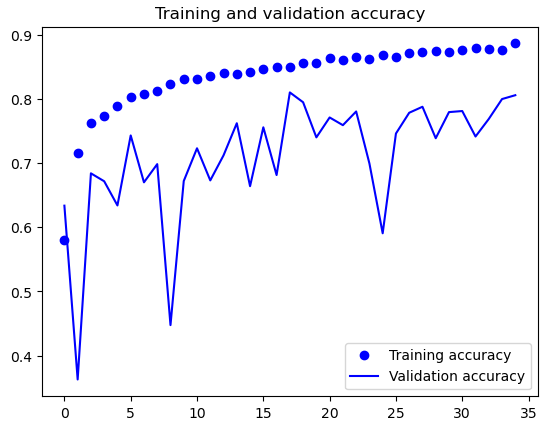

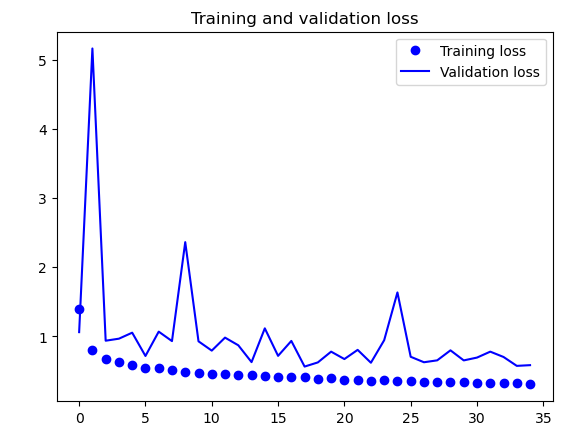

In the end the model reached 80% of accuracy over the validation set, also the peaks were reduced, but we thought that we could get even a better result

### Seventh model

The seventh model is using the same convolutional layers, but we are using four of them with different size of filters and number of them, we also added one dense layer more

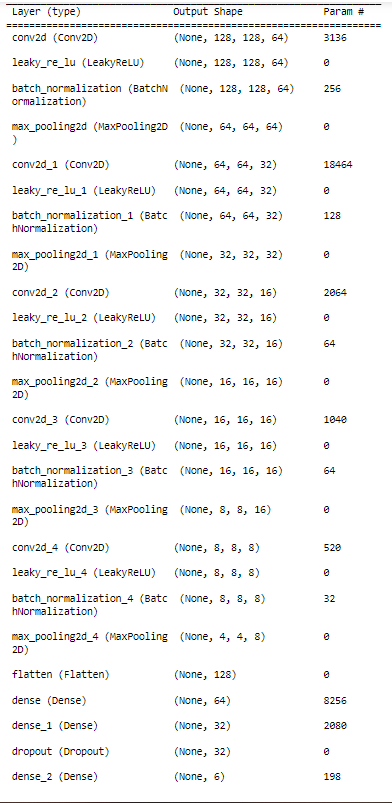

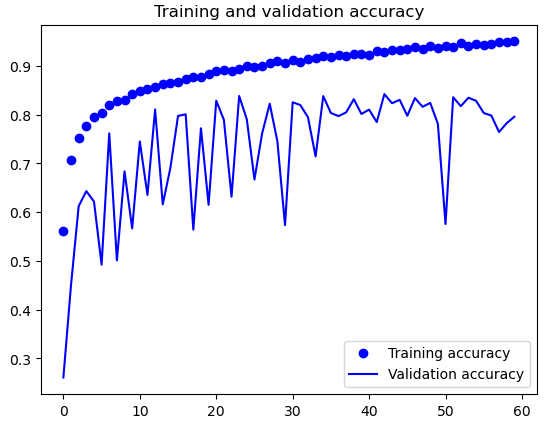

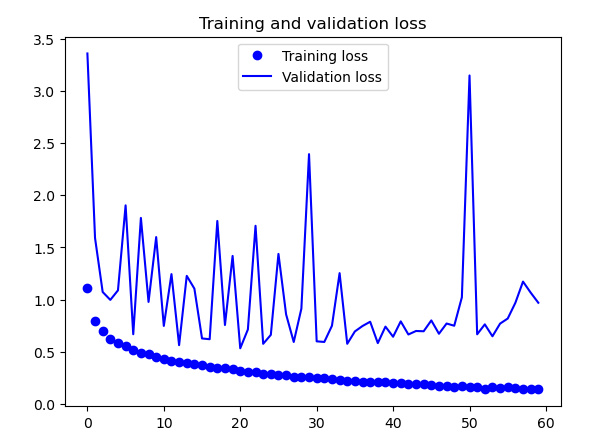

The model reached a solid 84% of accuracy, but we wanted to reduce the peaks, and check if we could get a higher accuracy

### Ninth model

For the last model we just added a new dropout layer and increased the parameter of both to 0.5, the architecure is presented in the next section

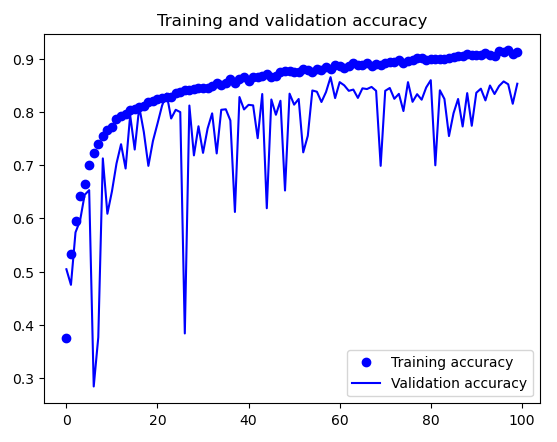

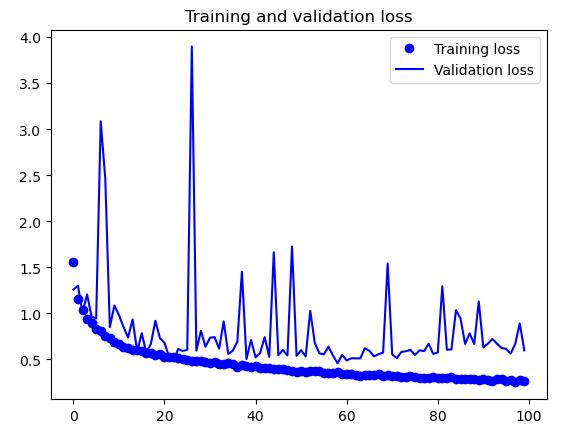

After a 100 epochs, the model reached 86.5% of accuracy over the validation set, we also can see that the peaks were reduced

# Ninth model run

In [39]:
model = Sequential()
model.add(Conv2D(64 ,(4,4),input_shape = (128,128,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (2,2),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, (2,2),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8, (2,2),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense (6, activation=tf.nn.softmax))

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

In [41]:
runNum="9"
modelans =model.fit(X_Train, Y_Train, batch_size=32, epochs=100,validation_data=(X_Test, Y_Test),callbacks=[ModelCheckpoint(filepath='my_best_model'+runNum+'.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', save_best_only=True)])

Epoch 1/100
439/439 [==============================] - 30s 64ms/step - loss: 1.5551 - accuracy: 0.3760 - val_loss: 1.2592 - val_accuracy: 0.5043
Epoch 2/100
439/439 [==============================] - 26s 60ms/step - loss: 1.1623 - accuracy: 0.5324 - val_loss: 1.3013 - val_accuracy: 0.4750
Epoch 3/100
439/439 [==============================] - 27s 60ms/step - loss: 1.0414 - accuracy: 0.5955 - val_loss: 1.0063 - val_accuracy: 0.5737
Epoch 4/100
439/439 [==============================] - 27s 60ms/step - loss: 0.9449 - accuracy: 0.6424 - val_loss: 1.2067 - val_accuracy: 0.5957
Epoch 5/100
439/439 [==============================] - 27s 61ms/step - loss: 0.8953 - accuracy: 0.6641 - val_loss: 0.9653 - val_accuracy: 0.6440
Epoch 6/100
439/439 [==============================] - 27s 61ms/step - loss: 0.8358 - accuracy: 0.7002 - val_loss: 0.9464 - val_accuracy: 0.6530
Epoch 7/100
439/439 [==============================] - 27s 61ms/step - loss: 0.8044 - accuracy: 0.7237 - val_loss: 3.0872 - val_ac

439/439 [==============================] - 26s 60ms/step - loss: 0.3578 - accuracy: 0.8790 - val_loss: 0.6393 - val_accuracy: 0.8187
Epoch 58/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3578 - accuracy: 0.8843 - val_loss: 0.5427 - val_accuracy: 0.8373
Epoch 59/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3603 - accuracy: 0.8814 - val_loss: 0.4584 - val_accuracy: 0.8653
Epoch 60/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3436 - accuracy: 0.8878 - val_loss: 0.5496 - val_accuracy: 0.8260
Epoch 61/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3371 - accuracy: 0.8858 - val_loss: 0.4896 - val_accuracy: 0.8560
Epoch 62/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3472 - accuracy: 0.8829 - val_loss: 0.5131 - val_accuracy: 0.8500
Epoch 63/100
439/439 [==============================] - 27s 61ms/step - loss: 0.3333 - accuracy: 0.8868 - val_loss: 0.5123 - val_accuracy

In [42]:
model.save('modelRun'+runNum)

INFO:tensorflow:Assets written to: modelRun9\assets


INFO:tensorflow:Assets written to: modelRun9\assets


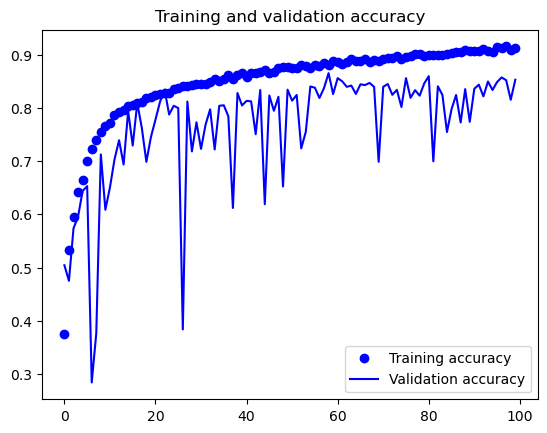

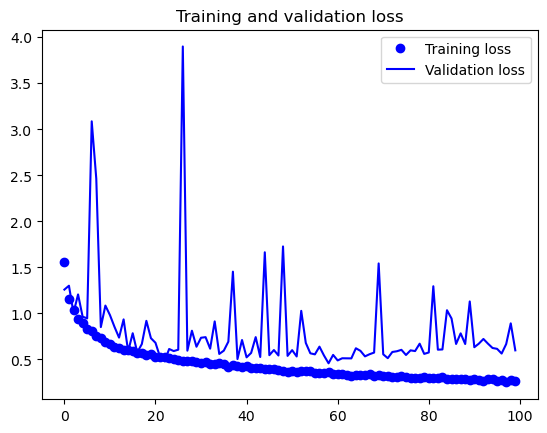

In [43]:
accuracy = modelans.history['accuracy']
val_accuracy = modelans.history['val_accuracy']
loss = modelans.history['loss']
val_loss = modelans.history['val_loss']

printResults(accuracy,val_accuracy,loss,val_loss)

In [44]:
newModel=loadModelAndPrintData('bestRuns/my_best_model9.epoch59-loss0.46.hdf5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 32)       

Generate predictions for 3 samples
79/79 [==============================] - 1s 19ms/step
predictions shape: (2500, 6)
sea


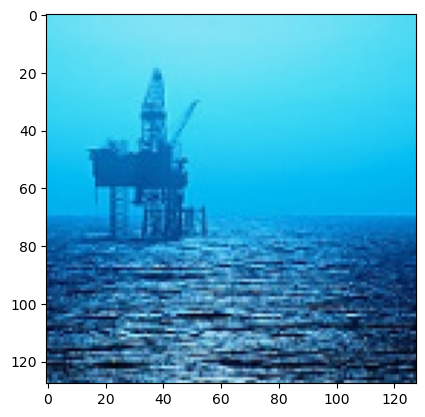

In [59]:
print("Generate predictions for 3 samples")
predictions = newModel.predict(X_Test[0:2500])
print("predictions shape:", predictions.shape)
prediction=2200
print(classes[np.argmax(predictions[prediction])])
plt.imshow(X_Test[prediction])
plt.show()

In [19]:
loadModelAndPrintData('SavedModels/modelRun9')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 32)       

NameError: name 'X_Test' is not defined

In [12]:
imgsArray=getImagesFromAFolder(pathToImagesTrain+"\\buildings",True)


(2191, 128, 128, 3)


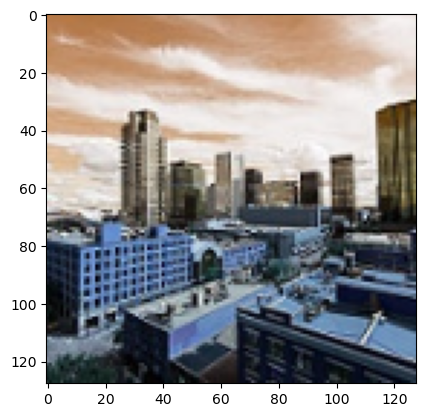

In [31]:
plt.imshow(imgsArray[1])
plt.show()

# using non-labeled images:

In [17]:

def getImagesWithoutLabels(pathToImages,resize=False,resizeSize=128,gray=False):
    totalImgs=0
    channels = 3
    if (gray):
        channels=1
    X = []
    imgsFromClass=getImagesFromAFolder(pathToImages,True,resizeSize,False)
    totalImgs+=len(imgsFromClass)
    X.extend(imgsFromClass)
    X = np.array(X)
    X = X.reshape((totalImgs, resizeSize, resizeSize, channels))
    return (X)

In [18]:
X_Pred=getImagesWithoutLabels(pathToImages=pathToImagesPred,resize=True,resizeSize=128,gray=False)

(7301, 128, 128, 3)


In [22]:
#saveDataPickle('imagesProcessedPickles/xPred.Pickle',X_Pred)

In [23]:
X_Pred=loadDataPickle('imagesProcessedPickles/xPred.pickle')

In [24]:
newModel= loadModelAndPrintData('SavedModels/modelRun9')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 32)       

In [26]:
import random

In [36]:
num_Images = 10
random.seed(42)
image_indices = random.sample(range(len(X_Pred)), num_Images)
images_to_predict = X_Pred[image_indices]

Generating random prediction
1/1 [==============================] - 0s 53ms/step
Predictions shape: (10, 6)
Prediction for image 1 : buildings


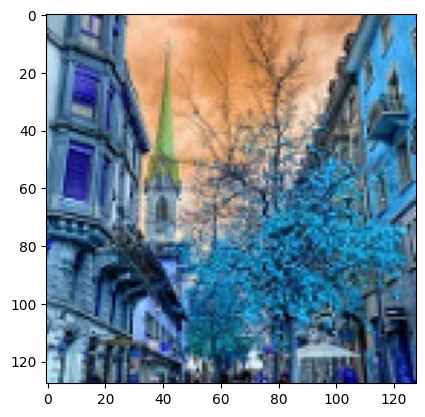

Prediction for image 2 : mountain


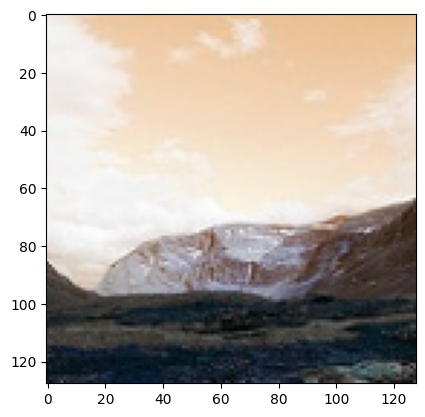

Prediction for image 3 : street


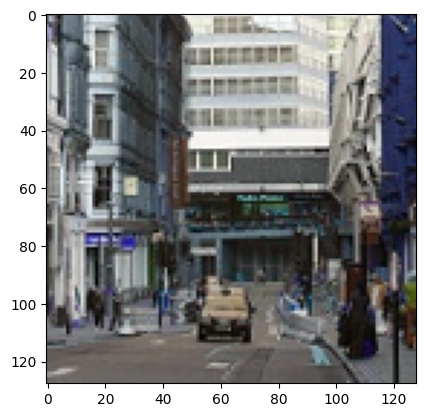

Prediction for image 4 : mountain


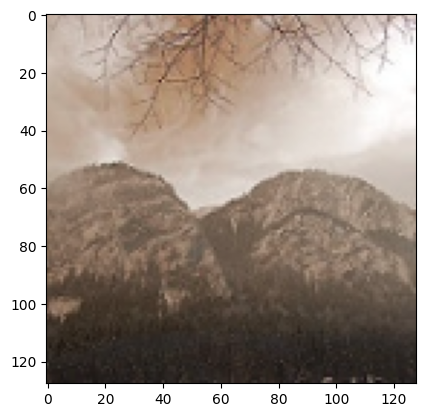

Prediction for image 5 : mountain


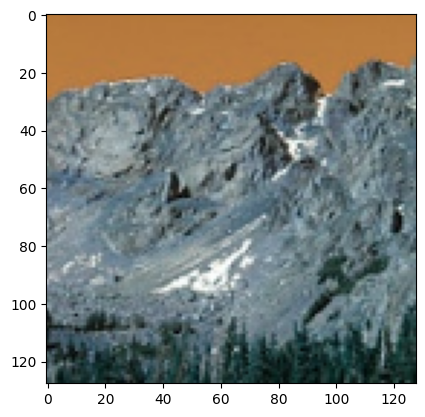

Prediction for image 6 : forest


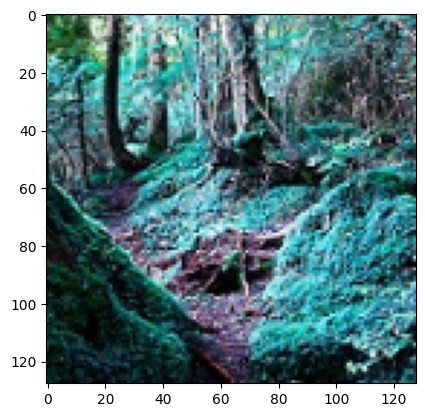

Prediction for image 7 : sea


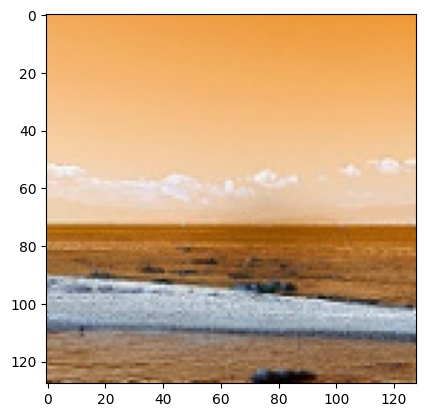

Prediction for image 8 : glacier


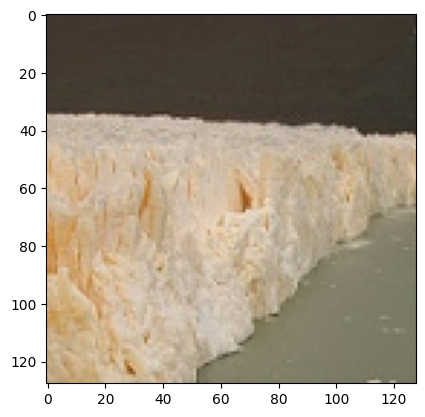

Prediction for image 9 : sea


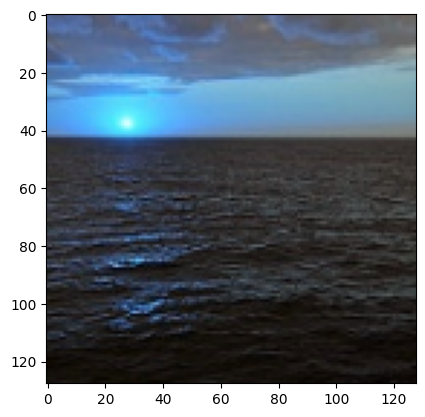

Prediction for image 10 : buildings


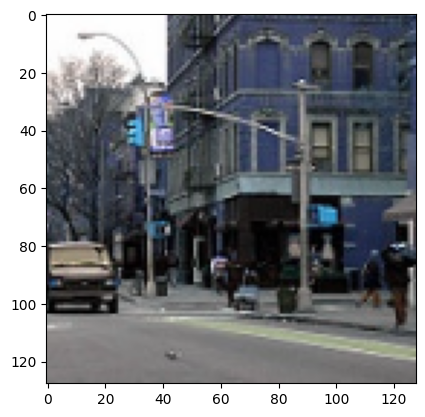

In [38]:
print("Generating random prediction")
predictions = newModel.predict(X_Pred[:num_Images])
print("Predictions shape:", predictions.shape)
for i in range(num_Images):
    print("Prediction for image", i+1, ":", classes[np.argmax(predictions[i])])
    plt.imshow(X_Pred[i])
    plt.show()

# transfer Learning

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

We used VGG16 as it is a powerful pre-trained CNN architecture that can be used for various image classification tasks by either using it as a feature extractor or fine-tuning it for specific tasks.

The VGG16 architecture has been pre-trained on the ImageNet dataset, which contains millions of labeled images, and can be used as a feature extractor or fine-tuned for specific image classification tasks.

VGG16 uses small 3x3 convolutional filters throughout the network, which helps it to learn more complex features and recognize patterns in the images. It also uses max pooling layers to reduce the dimensionality of the feature maps and control overfitting.

There are various pre-trained CNN arquitectures available online, but this is one of the most commonly used in examples with styles similar to the current exercise.

In [14]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

We freeze the model so it retains the already learned features. It prevents them from being modified during the training process.

In [15]:
for layer in vgg.layers:
    layer.trainable = False

We trained the model 3 times using different layers. For the second layer, we used the last layers that we used in our model9, which gave us the best accuracy, but this only resulted in a 77% accuracy. Therefore, we tried training again using only 1 dense layer of 32 layers and the softmax layer to achieve our results. Training models using this type of architecture takes more time than our custom models, so the number of layers is more limited.

## second model

![accuracy second model](resultsOfModelsGraphs\Model2VGG16\trainingModel2.PNG)

![accuracy second model](resultsOfModelsGraphs\Model2VGG16\lossModel2.PNG)

In this architecture, we used the following layers after freezing the model.

- x = Dense(64, activation='relu')(x)
- x = Dropout(0.5)(x)
- x = Dense(32, activation='relu')(x)
- x = Dropout(0.5)(x)
- output = Dense(6, activation='softmax')(x)

But we noticed that this did not give us the best results, so we tried the model using the following:

## third model

- x = Dense(32, activation='relu')(x)
- predictions = Dense(6, activation='softmax')(x)

This gave us better results, and in just 10 epochs we were able to achieve an accuracy of 90 with very low test_loss compared to the previous model.

![accuracy second model](resultsOfModelsGraphs\Model3VGG16\accuracymodel3.PNG)

![accuracy second model](resultsOfModelsGraphs\Model3VGG16\lossmodel3.PNG)

The procedure for this experiment is as follows:

In [16]:
x = Flatten()(vgg.output)
x = Dense(32, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)


In [17]:
model = Model(inputs=vgg.input, outputs=predictions)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
runNum="3VGG16"
modelans =model.fit(X_Train, Y_Train, batch_size=32, epochs=10,validation_data=(X_Test, Y_Test),callbacks=[ModelCheckpoint(filepath='my_best_model'+runNum+'.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5', save_best_only=True)])

Epoch 1/10
439/439 [==============================] - 425s 966ms/step - loss: 0.6389 - accuracy: 0.8494 - val_loss: 0.3862 - val_accuracy: 0.8830
Epoch 2/10
439/439 [==============================] - 426s 970ms/step - loss: 0.2735 - accuracy: 0.9130 - val_loss: 0.3943 - val_accuracy: 0.8767
Epoch 3/10
439/439 [==============================] - 426s 971ms/step - loss: 0.2192 - accuracy: 0.9327 - val_loss: 0.3857 - val_accuracy: 0.9020
Epoch 4/10
439/439 [==============================] - 428s 976ms/step - loss: 0.1675 - accuracy: 0.9433 - val_loss: 0.4120 - val_accuracy: 0.8960
Epoch 5/10
439/439 [==============================] - 428s 976ms/step - loss: 0.1372 - accuracy: 0.9535 - val_loss: 0.3924 - val_accuracy: 0.9077
Epoch 6/10
439/439 [==============================] - 432s 984ms/step - loss: 0.1106 - accuracy: 0.9597 - val_loss: 0.4173 - val_accuracy: 0.9030
Epoch 7/10
439/439 [==============================] - 420s 957ms/step - loss: 0.0975 - accuracy: 0.9672 - val_loss: 0.4636 -

In [20]:
model.save('modelRun'+runNum)

INFO:tensorflow:Assets written to: modelRun3VGG16\assets


INFO:tensorflow:Assets written to: modelRun3VGG16\assets


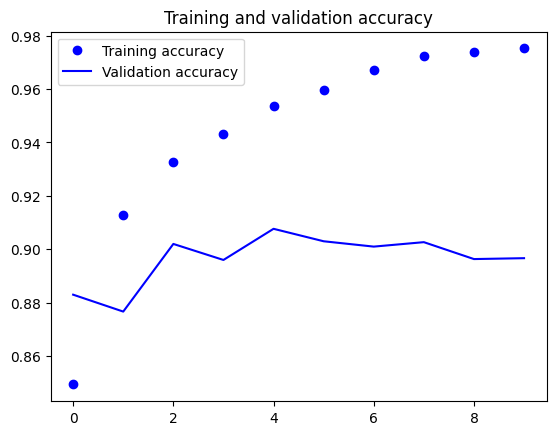

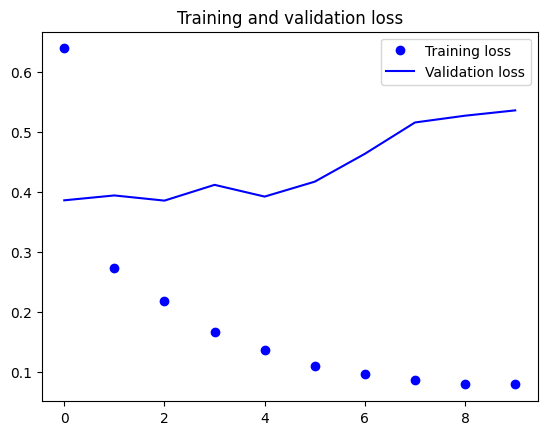

In [21]:
accuracy = modelans.history['accuracy']
val_accuracy = modelans.history['val_accuracy']
loss = modelans.history['loss']
val_loss = modelans.history['val_loss']

printResults(accuracy,val_accuracy,loss,val_loss)

In [22]:
newModel=loadModelAndPrintData('bestRuns/my_best_model3VGG16.epoch03-loss0.39.hdf5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

After running the model with a pre-trained architecture and comparing it with our own architecture, we realized that it's sometimes better to use pre-existing models found online since they contain more images and give better results. However, this is not always the case and there are instances where accuracy drops significantly due to parameter interference. It's a more efficient way of training models if you have a clear idea of how your CNN works. 

It's also important to note that training for 10 epochs using VGG16 took approximately 90 to 120 minutes, making it a slower process.

# links

- https://keras.io/api/applications/vgg/
- https://keras.io/guides/transfer_learning/
- https://keras.io/api/applications/
